### 1. Load and Preprocess Data


In [1]:
import pandas as pd
import numpy as np

# Load the CSV files into DataFrames
df_seq_info = pd.read_csv('/home/linxy29/data/CIVET/cancerstage_mutation/elife02935s001.csv')        # Sequencing info for tumor-normal pairs
df_mutations = pd.read_csv('/home/linxy29/data/CIVET/cancerstage_mutation/elife02935s002.csv')       # Catalog of mtDNA mutations (substitutions, indels, polymorphisms)
df_late = pd.read_csv('/home/linxy29/data/CIVET/cancerstage_mutation/s001_Late_metastatic_relapse.csv')  # List of samples that are Late (Metastatic/Relapse)

# Extract relevant columns from sequencing info (e.g., Tumour_sampleID) 
# to get the full list of tumor sample IDs.
df_seq_info = df_seq_info[['index', 'TumourTypes']].drop_duplicates()

# Create a DataFrame of all unique tumor sample IDs and assign stage classification
df_samples = df_mutations[['sample_Index']].drop_duplicates()
df_samples['Stage'] = np.where(df_samples['sample_Index'].isin(df_late['index']),
                               'Late (Metastatic/Relapse)', 'Primary')
df_samples = pd.merge(df_samples, df_seq_info, left_on='sample_Index', right_on='index', how='left')

# Merge the stage classification into the mutations DataFrame
# This adds a new column "Stage" to each mutation record based on its Tumour_sampleID
df_mutations = pd.merge(df_mutations, df_samples, on='sample_Index', how='left')

# Preview the first few rows to verify the merge (optional)
print(df_mutations[['sample_Index', 'mtDNA_pos', 'Stage', 'TumourTypes']].head())


   sample_Index  mtDNA_pos    Stage TumourTypes
0          15.0     1806.0  Primary      Breast
1          15.0     2300.0  Primary      Breast
2          16.0      152.0  Primary      Breast
3          16.0     1422.0  Primary      Breast
4          16.0     2143.0  Primary      Breast


### 2. Count mtDNA Mutations per Sample

In [3]:
# Count unique mtDNA mutations per sample
mutation_counts = df_mutations.groupby('sample_Index')['mtDNA_pos'].nunique().reset_index()
mutation_counts.columns = ['sample_Index', 'mtDNA_mutation_count']

# Merge the counts with the sample stage information to include samples with zero mutations
df_stage_mutationCount = pd.merge(df_samples, mutation_counts, on='sample_Index', how='left')
df_stage_mutationCount['mtDNA_mutation_count'] = df_stage_mutationCount['mtDNA_mutation_count'].fillna(0).astype(int)

# Preview the mutation counts DataFrame
print(df_stage_mutationCount.head())
print(df_stage_mutationCount['Stage'].value_counts())  # Just to see count of Primary vs Late samples

   sample_Index    Stage  index TumourTypes  mtDNA_mutation_count
0          15.0  Primary   15.0      Breast                     2
1          16.0  Primary   16.0      Breast                     4
2          19.0  Primary   19.0    Melanoma                     3
3          20.0  Primary   20.0    Melanoma                     5
4          21.0  Primary   21.0         MPD                     1
Stage
Primary                      942
Late (Metastatic/Relapse)     35
Name: count, dtype: int64


### 3. Generate Visualizations

/tmp/ipykernel_21269/387834193.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


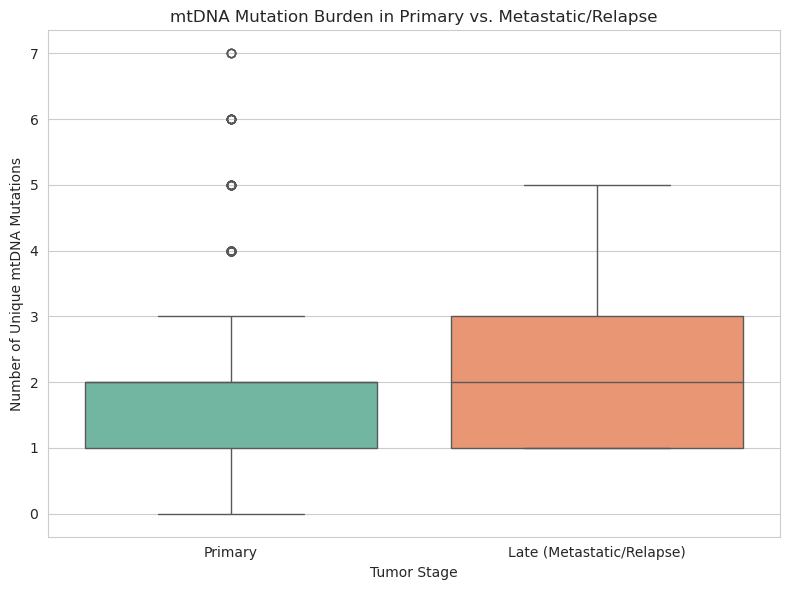

Normality test (Shapiro-Wilk) results:
Primary stage: p-value = 1.0236712504743487e-33
Late stage: p-value = 7.093669575877889e-05

At least one group is not normally distributed. Performing Mann-Whitney U test...
Mann-Whitney U test p-value: 0.1471301214607328


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Set plot style for better readability
sns.set_style("whitegrid")

# Boxplot visualization
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='Stage', 
    y='mtDNA_mutation_count',
    data=df_stage_mutationCount,
    order=['Primary', 'Late (Metastatic/Relapse)'],
    palette='Set2'
)
plt.title('mtDNA Mutation Burden in Primary vs. Metastatic/Relapse')
plt.xlabel('Tumor Stage')
plt.ylabel('Number of Unique mtDNA Mutations')
plt.tight_layout()

# Save the plot
plt.savefig("primary_vs_late_mtDNA_mutation_boxplot.png")
plt.show()

# Extract mutation counts for Primary and Late stages
primary_mutations = df_stage_mutationCount[df_stage_mutationCount['Stage'] == 'Primary']['mtDNA_mutation_count']
late_mutations = df_stage_mutationCount[df_stage_mutationCount['Stage'] == 'Late (Metastatic/Relapse)']['mtDNA_mutation_count']

# Check normality using Shapiro-Wilk test
primary_normality = stats.shapiro(primary_mutations)
late_normality = stats.shapiro(late_mutations)

print("Normality test (Shapiro-Wilk) results:")
print(f"Primary stage: p-value = {primary_normality.pvalue}")
print(f"Late stage: p-value = {late_normality.pvalue}")

# If both datasets are normally distributed, perform t-test; otherwise, perform Mann-Whitney U test
if primary_normality.pvalue > 0.05 and late_normality.pvalue > 0.05:
    print("\nBoth groups are normally distributed. Performing t-test...")
    t_stat, p_ttest = stats.ttest_ind(primary_mutations, late_mutations)
    print(f"T-test p-value: {p_ttest}")
else:
    print("\nAt least one group is not normally distributed. Performing Mann-Whitney U test...")
    u_stat, p_mannwhitney = stats.mannwhitneyu(primary_mutations, late_mutations)
    print(f"Mann-Whitney U test p-value: {p_mannwhitney}")

### VAF

In [27]:
import pandas as pd
import numpy as np

# Load the CSV files into DataFrames
df_seq_info = pd.read_csv('/home/linxy29/data/CIVET/cancerstage_mutation/elife02935s001.csv')        # Sequencing info for tumor-normal pairs
df_mutations = pd.read_csv('/home/linxy29/data/CIVET/cancerstage_mutation/elife02935s002.csv')       # Catalog of mtDNA mutations (substitutions, indels, polymorphisms)
df_late = pd.read_csv('/home/linxy29/data/CIVET/cancerstage_mutation/s001_Late_metastatic_relapse.csv')  # List of samples that are Late (Metastatic/Relapse)

# Extract relevant columns from sequencing info (e.g., Tumour_sampleID) 
# to get the full list of tumor sample IDs.
df_seq_info = df_seq_info[['index', 'TumourTypes']].drop_duplicates()

# Create a DataFrame of all unique tumor sample IDs and assign stage classification
df_samples = df_mutations[['sample_Index']].drop_duplicates()
df_samples['Stage'] = np.where(df_samples['sample_Index'].isin(df_late['index']),
                               'Late (Metastatic/Relapse)', 'Primary')
df_samples = pd.merge(df_samples, df_seq_info, left_on='sample_Index', right_on='index', how='left')

# Merge the stage classification into the mutations DataFrame
# This adds a new column "Stage" to each mutation record based on its Tumour_sampleID
df_mutations = pd.merge(df_mutations, df_samples, on='sample_Index', how='left')

# Preview the first few rows to verify the merge (optional)
print(df_mutations[['sample_Index', 'mtDNA_pos', 'Stage', 'TumourTypes', 'VAF(T)']].head())

   sample_Index  mtDNA_pos    Stage TumourTypes  VAF(T)
0          15.0     1806.0  Primary      Breast  0.1001
1          15.0     2300.0  Primary      Breast  0.3764
2          16.0      152.0  Primary      Breast  0.7970
3          16.0     1422.0  Primary      Breast  0.0951
4          16.0     2143.0  Primary      Breast  0.2812


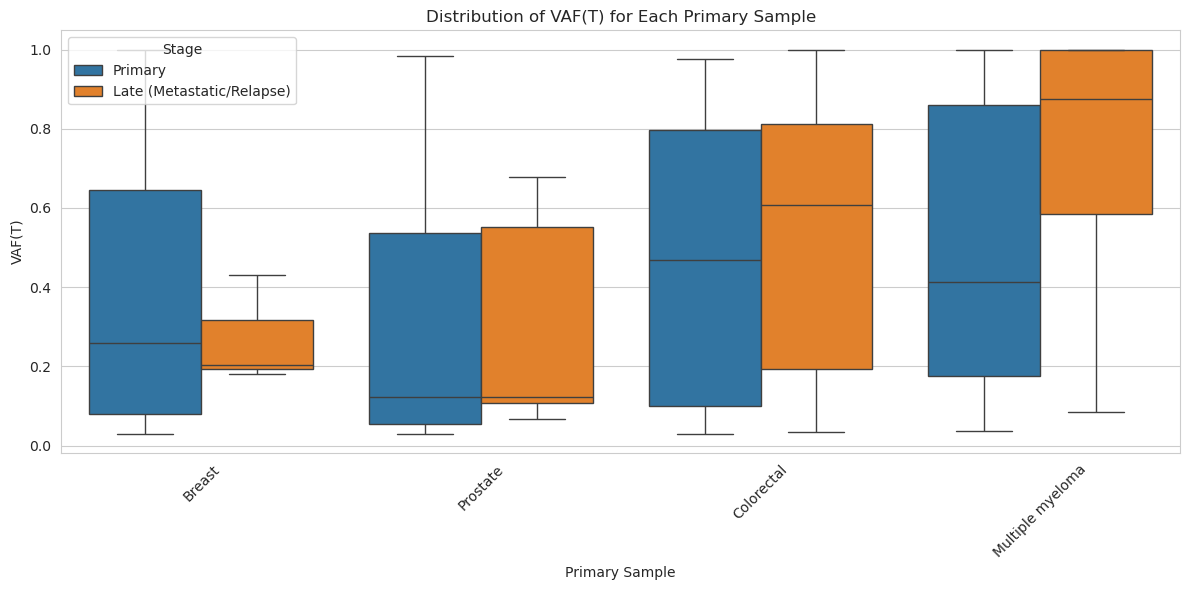

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify TumourTypes that contain both Primary and Late stages
valid_tumour_types = df_mutations.groupby('TumourTypes')['Stage'].nunique()
valid_tumour_types = valid_tumour_types[valid_tumour_types == 2].index  # Keep only those with both stages

# Filter DataFrame to include only TumourTypes that have both Primary and Late stages
df_filtered = df_mutations[df_mutations['TumourTypes'].isin(valid_tumour_types)]

# Using a boxplot to compare distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x="TumourTypes", y="VAF(T)", hue='Stage', data=df_filtered)
plt.title("Distribution of VAF(T) for Each Primary Sample")
plt.xlabel("Primary Sample")
plt.ylabel("VAF(T)")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()
plt.show()


/home/linxy29/.conda/envs/daily/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/linxy29/.conda/envs/daily/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/linxy29/.conda/envs/daily/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/linxy29/.conda/envs/daily/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/linxy29/.conda/envs/daily/

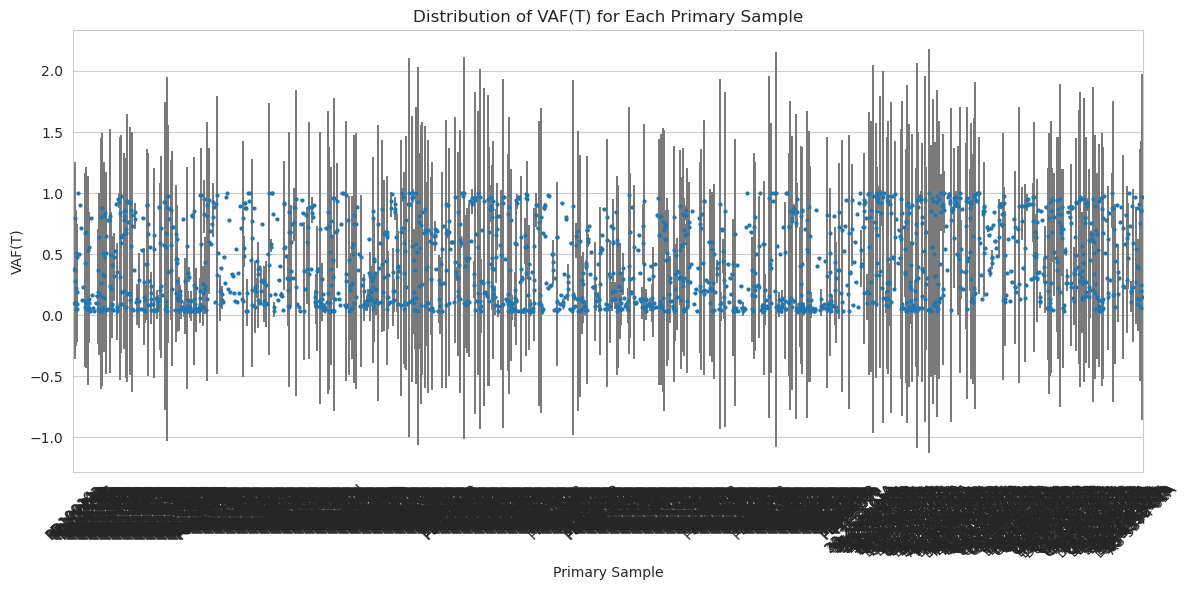

In [30]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="Tumour_sampleID", y="VAF(T)", hue='Stage', data=df_mutations, inner=None, color=".8")
sns.swarmplot(x="Tumour_sampleID", y="VAF(T)", data=df_mutations, size=3)
plt.title("Distribution of VAF(T) for Each Primary Sample")
plt.xlabel("Primary Sample")
plt.ylabel("VAF(T)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
